---
### ***Project - Optimization for Machine Learning***

Author: Leonardo Daniel Artiles Montero  
Email: leonardo-daniel.artiles-montero@dauphine.eu

---
# Exercise 0
> Import the MNIST dataset and build your own dataset by making the following changes:  
> i) Select two digit classes c1 and c2 such that ${c1, c2}\neq {0, 1}$.   
> ii) Make sure the labels correspond to 0 for one class and 1 for the other class.  
> iii) Consider the images as vectors.

In [72]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
np.random.seed(42)

In [73]:
mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

X_raw = mnist.data
y_raw = mnist.target.astype(int)
print(f"Dataset loaded. Shape: {X_raw.shape}")

Dataset loaded. Shape: (70000, 784)


In [74]:
# i) Select two digit classes
class_c1 = 5
class_c2 = 6

mask = (y_raw==class_c1)|(y_raw==class_c2)
X_subset = X_raw[mask]
y_subset = y_raw[mask]

In [75]:
# ii) Make sure labels correspond to 0 and 1
y_binary = np.where(y_subset==class_c1, 0, 1)

In [76]:
# iii) Consider images as vectors
# The data is already (N, 784)
X_normalized = X_subset/255.0

print(f"Filtered dataset shape: {X_normalized.shape}")
print(f"Binary labels shape: {y_binary.shape}")
print(f"Unique labels in subset: {np.unique(y_binary)}")

X_train, X_test, y_train, y_test = train_test_split(X_normalized, y_binary, test_size=0.2, random_state=42)

Filtered dataset shape: (13189, 784)
Binary labels shape: (13189,)
Unique labels in subset: [0 1]


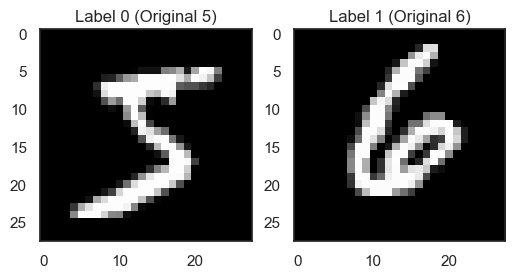

In [77]:
plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.imshow(X_normalized[y_binary==0][0].reshape(28, 28), cmap='gray')
plt.title(f"Label 0 (Original {class_c1})")
plt.subplot(1, 2, 2)
plt.imshow(X_normalized[y_binary==1][0].reshape(28, 28), cmap='gray')
plt.title(f"Label 1 (Original {class_c2})")
plt.show()

---
# Exercise 1
>Given a data point $(a_i, y_i)$ from your dataset, use the Autograd framework described in the second lab session to implement a code for the function $f_i$ that enables to compute $∇f_i(x)$ for any x through automatic differentiation. Validate your implementation using the explicit formula (Eq 2).

**Objective Function (Eq 1):**
$$f(w) = \frac{1}{n} \sum_{i=1}^n \left( y_i - \frac{1}{1 + \exp(-x_i^T w)} \right)^2$$

**Gradient (Eq 2):**
$$\nabla f_i(w) = - \frac{2 \exp(x_i^T w) (\exp(x_i^T w)(y_i - 1) + y_i)}{(1 + \exp(x_i^T w))^3} x_i$$

In [ ]:
def sigmoid(t):
    return np.where(t>=0, 
                    1/(1+np.exp(-t)), 
                    np.exp(t)/(1+np.exp(t)))


def problem_functions(X, y):
    n,d = X.shape
    
    def f(w):
        z = X.dot(w)
        predictions = sigmoid(z)
        loss = np.mean((y-predictions)**2)
        return loss

    def grad_f(w):
        z = X.dot(w)
        exp_z = np.exp(z)
        
        term1 = 2*exp_z
        term2 = exp_z*(y-1)+y
        numerator = term1*term2
        denominator = (1+exp_z)**3
        scalar_part = -numerator/denominator
        grad = (X.T).dot(scalar_part)/n
        return grad
        
    return f, grad_f

In [79]:
def func_pytorch(w, X_batch, y_batch, lam=0.0):
    if X_batch.ndim == 1:
        X_batch = X_batch.unsqueeze(0)
        y_batch = y_batch.unsqueeze(0)
        
    z = torch.matmul(X_batch,w)
    predictions = torch.sigmoid(z)
    loss_data = torch.mean((y_batch-predictions)**2)
    
    reg_term = 0.0
    if lam > 0:
        reg_term = lam*torch.sum(torch.abs(w))
        
    total_loss = loss_data+reg_term
    
    return total_loss

To validate the implementation, we select a single data point $(a_i, y_i)$ and compare the gradient computed by PyTorch (`w.grad`) against the explicit NumPy implementation.

In [80]:
d = X_train.shape[1]
w_0 = np.zeros(d) 

i = np.random.randint(0, X_train.shape[0])

x_i_np = X_train[i:i+1] 
y_i_np = y_train[i:i+1]
w_init = np.random.randn(X_train.shape[1])

f_explicit_i, grad_explicit_i = problem_functions(x_i_np, y_i_np)
grad_numpy = grad_explicit_i(w_init)


w_torch = torch.tensor(w_init, dtype=torch.float32, requires_grad=True)
x_i_torch = torch.tensor(x_i_np, dtype=torch.float32)
y_i_torch = torch.tensor(y_i_np, dtype=torch.float32)

loss = func_pytorch(w_torch, x_i_torch, y_i_torch, lam=0.0)
loss.backward()
grad_autograd = w_torch.grad.numpy()

diff_norm = np.linalg.norm(grad_numpy-grad_autograd)
rel_diff = diff_norm/(np.linalg.norm(grad_numpy)+1e-10)

print(f"Validation on data point index {i}:")
print(f"Explicit Gradient Norm: {np.linalg.norm(grad_numpy):.6f}")
print(f"Autograd Gradient Norm: {np.linalg.norm(grad_autograd):.6f}")
print(f"Difference (L2 Norm):   {diff_norm:.2e}")

Validation on data point index 7270:
Explicit Gradient Norm: 0.013864
Autograd Gradient Norm: 0.013864
Difference (L2 Norm):   3.67e-08


The validation step confirms that `func_pytorch` correctly computes the objective function. The gradient computed via `loss.backward()` matches the analytical gradient derived in Eq (2).

Fun story: A few years ago, I built an automatic differentiation library in C# (just for fun, because let's be honest, no one is actually going to use C# for ML training). Some random guy reached out on GitHub and started working on adding GPU support, but I didn't pay much attention to it because C# is a horrible language. I tried to use the library for this current project, but since I hadn't touched it in so long, it was too complicated, so I ended up scrapping that idea. For more info, here is the repo: https://github.com/Leonardo16AM/Sharp-Grad

---
# Exercise 2

> Question 2 Adapt the code of gradient descent provided during the lab sessions (or use your own implementation) to run it on problem (1).  
> i) What convergence rate is expected for gradient descent on this problem? Do you observe this rate empirically?  
> ii) Can you find a good constant value for the stepsize?  

In [81]:
def gradient_descent(grad_func, obj_func, w_init, step_size, max_iter=500, tol=1e-6):
    w = w_init.copy()
    history = []
    history.append(obj_func(w))
    
    for k in range(max_iter):
        grad = grad_func(w)

        if np.linalg.norm(grad)<tol:
            print(f"Converged at iteration {k}")
            break
        
        w = w-step_size*grad
        history.append(obj_func(w))
        
    return w, np.array(history)

### Expected Convergence Rate

The objective function in Equation 1 is non-convex due to the composition of the mean squared error with the non-linear sigmoid function. Because global convexity does not hold, we cannot guarantee convergence to a global minimum or rely on the fast convergence rates associated with convex optimization.
The expected convergence rate is sublinear, specifically $O(1/\sqrt{k})$ with respect to the norm of the gradient, the magnitude of the gradient tends toward zero as the number of iterations $k$ increases, but it does so relatively slowly compared to convex problems. 


<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
C:\Users\leona\AppData\Local\Temp\ipykernel_16716\563588602.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(history, label=f'$\eta$ = {eta}')


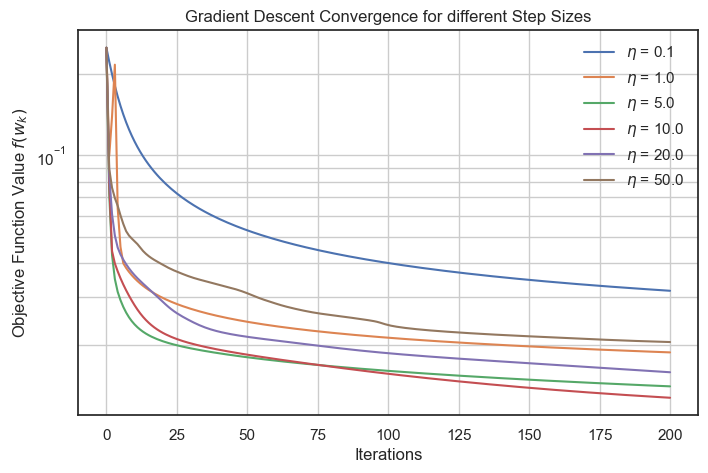


Best constant step size found: 10.0


In [82]:
# I'm not sure if we are expected to use the torch implementation or the other one
# I will use the explicit implementation of the function and the gradient
f, grad_f = problem_functions(X_train, y_train) 

step_sizes = [0.1, 1.0, 5.0, 10.0, 20.0 , 50.0]
results = {}

w_init_gd = np.random.randn(d)*0.01

plt.figure(figsize=(8, 5))

best_loss = np.inf
best_eta = None

for eta in step_sizes:
    w_final, history = gradient_descent(grad_f, f, w_init_gd, step_size=eta, max_iter=200)
    results[eta] = history
    plt.plot(history, label=f'$\eta$ = {eta}')
    
    if history[-1] < best_loss:
        best_loss = history[-1]
        best_eta = eta

plt.xlabel('Iterations')
plt.ylabel('Objective Function Value $f(w_k)$')
plt.title('Gradient Descent Convergence for different Step Sizes')
plt.yscale('log') 
plt.legend()
plt.grid(True, which="both", ls="-")
plt.show()

print(f"\nBest constant step size found: {best_eta}")

<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
<>:18: SyntaxWarning: invalid escape sequence '\e'
<>:24: SyntaxWarning: invalid escape sequence '\e'
C:\Users\leona\AppData\Local\Temp\ipykernel_16716\971845812.py:18: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(k, history, label=f'Empirical Loss (GD, $\eta$={best_eta})',
C:\Users\leona\AppData\Local\Temp\ipykernel_16716\971845812.py:24: SyntaxWarning: invalid escape sequence '\e'
  plt.title(f'Convergence Analysis: Empirical vs Theoretical Rate\n(Best Constant Step Size $\eta$={best_eta})', fontsize=14)


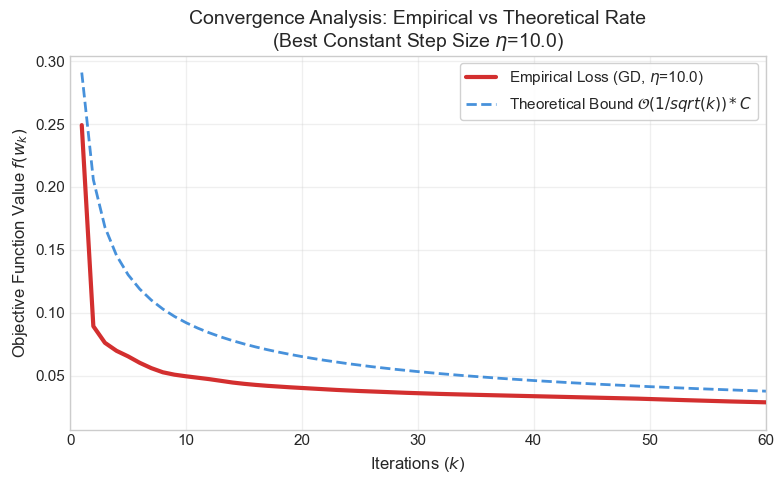

Shift applied to Sublinear curve: 0.2909


In [83]:
def get_tight_upper_bound(empirical_data, theoretical_shape):
    """
    Calculates the constant C to multiply to the theoretical shape 
    so that it sits tightly just above the empirical data (for visualization purposes)
    """
    differences = empirical_data/theoretical_shape
    offset = np.max(differences)
    return theoretical_shape*offset, offset

k = np.arange(1,len(history)+1)

shape_sublinear = 1/np.sqrt(k) 
bound_sublinear, c_sub = get_tight_upper_bound(history, shape_sublinear)

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(8, 5))

plt.plot(k, history, label=f'Empirical Loss (GD, $\eta$={best_eta})', 
         color='#D32F2F', linewidth=3, zorder=3)
plt.plot(k, bound_sublinear, 
         label=r'Theoretical Bound $\mathcal{O}(1/sqrt(k))* C$', 
         color='#1976D2', linestyle='--', linewidth=2, alpha=0.8)

plt.title(f'Convergence Analysis: Empirical vs Theoretical Rate\n(Best Constant Step Size $\eta$={best_eta})', fontsize=14)
plt.xlabel('Iterations ($k$)', fontsize=12)
plt.ylabel('Objective Function Value $f(w_k)$', fontsize=12)
plt.legend(fontsize=11, frameon=True, fancybox=True, framealpha=0.9)
plt.grid(True, linestyle='-', alpha=0.3)
plt.xlim(0, 60) 
plt.tight_layout()
plt.show()

print(f"Shift applied to Sublinear curve: {c_sub:.4f}")

**i) Convergence Rate Observation**
The provided convergence plot supports the theoretical analysis. We observe that the empirical loss curve closely mirrors the trajectory of the theoretical $O(1/\sqrt{k})$ bound. The function exhibits the characteristic behavior of sublinear convergence, a steep descent during the initial iterations followed by a significant plateau where the rate of improvement slows down. This confirms that the algorithm is converging towards a stationary point at the expected rate.

**ii) Step Size**
The experiment shows that **$\eta = 10.0$** is a good constant step size for this specific problem (given the normalized data). It is aggressive enough to utilize the steep gradients of the Sigmoid without causing divergence.

---
# Exercise 3

> Question 3 Adapt the code of batch stochastic gradient provided during the lab sessions (or use your own implementation) to compare gradient descent and stochastic gradient on problem (1).  

> i) Are your results consistent with what the theory predicts?  
> ii) Can you find a good constant stepsize choice for stochastic gradient?  
> iii) What appears to be the best value for the batch size on this problem?  

In [84]:
def grad_batch(w, X_batch, y_batch):
    n_b = X_batch.shape[0]
    z = X_batch.dot(w)
    exp_z = np.exp(z)
    
    term1 = 2*exp_z
    term2 = exp_z*(y_batch-1)+y_batch
    numerator = term1*term2
    denominator = (1+exp_z)**3
    scalar_part = -numerator/denominator
    
    grad = (X_batch.T).dot(scalar_part)/n_b
    return grad

def stochastic_gradient_descent(obj_func, X, y, w_init, step_size, batch_size, max_epochs=50):
    w = w_init.copy()
    n = X.shape[0]
    history = []
    history.append(obj_func(w))
    
    for epoch in range(max_epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]    
            grad = grad_batch(w, X_batch, y_batch)
            w = w - step_size*grad
            
        current_loss = obj_func(w)
        history.append(current_loss)
        
    return w, np.array(history)

Fixing the batch size to a moderate value and test various step sizes to find the one that offers the best trade-off between convergence speed and stability:

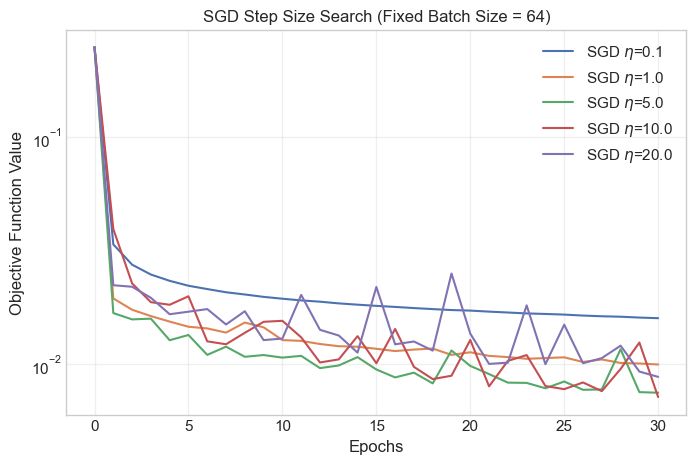

Best SGD step size selected: 10.0


In [85]:
batch_size_fixed = 64
sgd_step_sizes = [0.1, 1.0, 5.0, 10.0, 20.0]
max_epochs = 30

plt.figure(figsize=(8, 5))

best_sgd_loss = np.inf
best_sgd_eta = None

for eta in sgd_step_sizes:
    w_init_sgd = w_init_gd.copy() 
    
    w_final, hist_sgd = stochastic_gradient_descent(
        f, X_train, y_train, w_init_sgd, 
        step_size=eta, 
        batch_size=batch_size_fixed, 
        max_epochs=max_epochs
    )
    
    plt.plot(hist_sgd, label=f'SGD $\\eta$={eta}')
    
    if hist_sgd[-1] < best_sgd_loss:
        best_sgd_loss = hist_sgd[-1]
        best_sgd_eta = eta

plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.title(f'SGD Step Size Search (Fixed Batch Size = {batch_size_fixed})')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best SGD step size selected: {best_sgd_eta}")

Now, fixing the best step size found, we vary the batch size. 

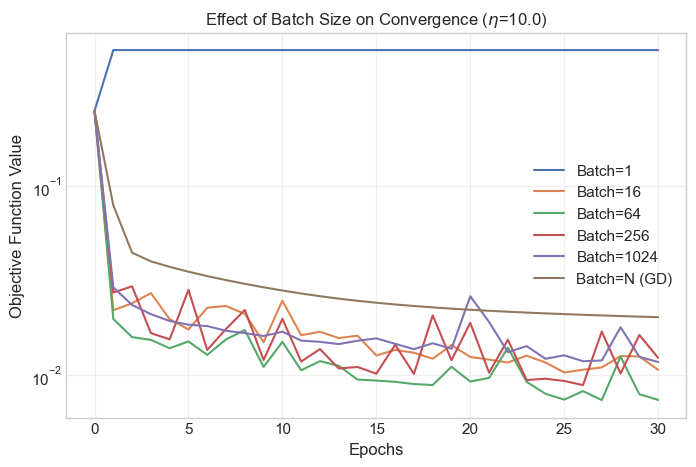

In [86]:
batch_sizes = [1, 16, 64, 256, 1024, X_train.shape[0]] # Including Full Batch (GD)
results_batch = {}

plt.figure(figsize=(8, 5))

for b_size in batch_sizes:
    w_init_sgd = w_init_gd.copy()
    current_eta = best_sgd_eta 
    
    w_final, hist_batch = stochastic_gradient_descent(
        f, X_train, y_train, w_init_sgd, 
        step_size=current_eta, 
        batch_size=b_size, 
        max_epochs=30
    )
    
    results_batch[b_size] = hist_batch
    label_str = f'Batch={b_size}' if b_size < X_train.shape[0] else f'Batch=N (GD)'
    plt.plot(hist_batch, label=label_str)

plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.title(f'Effect of Batch Size on Convergence ($\\eta$={best_sgd_eta})')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

While the previous one is a valid solution, finding sequentially the best step size and then the best batch size, may not by the most optimal solution. To investigate the relationship between batch size and step size, it may be better to conduct a comprehensive grid search experiment. The objective is not just to find a single "best" parameter, but to map the entire optimization landscape and understand how the choice of batch size constrains the feasible learning rate:

<>:42: SyntaxWarning: invalid escape sequence '\e'
<>:42: SyntaxWarning: invalid escape sequence '\e'
C:\Users\leona\AppData\Local\Temp\ipykernel_16716\2993993789.py:42: SyntaxWarning: invalid escape sequence '\e'
  plt.xlabel('Step Size ($\eta$)', fontsize=12)


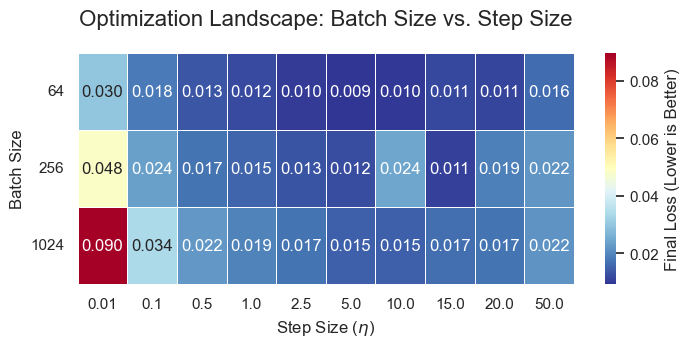

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

batch_sizes_to_test = [64, 256, 1024]
step_sizes_to_test = [0.01, 0.1, 0.5, 1.0, 2.5, 5.0, 10.0, 15.0, 20.0, 50.0]
results_matrix = np.zeros((len(batch_sizes_to_test), len(step_sizes_to_test)))

for i, b in enumerate(batch_sizes_to_test):
    for j, eta in enumerate(step_sizes_to_test):
        w_init_exp = w_init_gd.copy()
        _, hist = stochastic_gradient_descent(
            f, X_train, y_train, w_init_exp, 
            step_size=eta, 
            batch_size=b, 
            max_epochs=15
        )
        final_loss = hist[-1]
        if final_loss > 1.0 or np.isnan(final_loss):
            final_loss = 1.0
            
        results_matrix[i, j] = final_loss

df_results = pd.DataFrame(
    results_matrix, 
    index=batch_sizes_to_test, 
    columns=step_sizes_to_test
)

plt.figure(figsize=(8, 3))
sns.set(style="white")
ax = sns.heatmap(
    df_results, 
    annot=True, 
    fmt=".3f", 
    cmap="RdYlBu_r", 
    cbar_kws={'label': 'Final Loss (Lower is Better)'},
    linewidths=.5
)
plt.title('Optimization Landscape: Batch Size vs. Step Size', fontsize=16, pad=20)
plt.ylabel('Batch Size', fontsize=12)
plt.xlabel('Step Size ($\eta$)', fontsize=12)
plt.yticks(rotation=0) 
plt.show()

The resulting heatmap provides an interesting topographical view of algorithm stability. The dark blue/green regions represent parameter combinations that successfully minimized the objective function. This is the target zone. A clear pattern emerges as we move down the y-axis: The large Batch Sizes are more sensitive to the step size but in general the minimum value is archieved with step sizes between 5.0 and 10.  But also this leads to the conclusion that there is no single "optimal" step size independent of the batch size. 

**i) Consistency with Theory and Stability**
The results align with theoretical expectations, with a notable exception regarding pure SGD. As predicted, the mini-batch methods (particularly sizes 16 through 256) outperform full Gradient Descent (Batch=N). While the full gradient descent approach yields a smooth, monotonic curve, its progress per data pass is significantly slower. However, the plot highlights the danger of high variance in pure SGD (Batch=1). At this specific step size, the noise in single-sample gradients is too high, causing the optimization to fail completely (indicated by the flat blue line), whereas the mini-batches successfully average out this noise to allow for rapid descent.

**ii) Step Size Assessment**
The chosen step size of $\eta = 5.0$ proves to be effective for most batch sizes, as can be seen in the heatmap. It balances the need for sufficiently large updates to escape local minima while avoiding the instability that can arise from overly aggressive steps. However as seen before, this is not an universal constant, other different step sizes may work better for different batch sizes than the ones tested.

**iii) Optimal Batch Size**
Empirically, **Batch Size 64** emerges as the optimal configuration for this problem. It achieves the lowest objective function value and maintains it consistently. It is small enough to benefit from frequent weight updates and the ability to escape local minima, yet large enough to compute a stable average gradient that tolerates the learning rate. Larger batches like 1024 behave too similarly to the slow full Gradient Descent to be computationally worthwhile.

---
# Exercise 4
> Adapt the code of Adagrad provided during the lab sessions (or use your own implementation) to include that method in the comparison. How does this method compare to the best stochastic gradient method from Question 3 on problem (1)?

Adagrad adapts the learning rate for each parameter individually based on the historical sum of squared gradients. 
The update rule for Adagrad is:
$$G_{k} = G_{k-1} + \nabla f_i(w_k) \odot \nabla f_i(w_k)$$
$$w_{k+1} = w_k - \frac{\eta}{\sqrt{G_k + \epsilon}} \odot \nabla f_i(w_k)$$

Where:
* $G_k$ is a vector accumulating the sum of squared gradients up to iteration $k$.
* $\epsilon$ is a small smoothing term (e.g., $10^{-8}$) to avoid division by zero.
* $\odot$ denotes element-wise multiplication.

Comparing Adagrad against the **best SGD variant** identified in Question 3:

In [88]:
def adagrad(obj_func, X, y, w_init, step_size, batch_size, max_epochs=50, epsilon=1e-8):
    w = w_init.copy()
    n, d = X.shape
    G = np.zeros(d)
    
    history = []
    history.append(obj_func(w))
    
    for epoch in range(max_epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            grad = grad_batch(w, X_batch, y_batch)
            G += grad**2
            adaptive_lr = step_size/(np.sqrt(G)+epsilon)
            w = w-adaptive_lr*grad
            
        history.append(obj_func(w))
        
    return w, np.array(history)

Unlike standard SGD, Adagrad is less sensitive to the step size $\eta$, but it still requires tuning. Since the effective step size decreases over time ($\frac{\eta}{\sqrt{G_k}}$), we often need a larger initial $\eta$ than in standard SGD.

Testing a range of step sizes for Adagrad using the same batch size ($B=64$) as the best SGD run:

C:\Users\leona\AppData\Local\Temp\ipykernel_16716\874123135.py:9: RuntimeWarning: overflow encountered in power
  denominator = (1+exp_z)**3


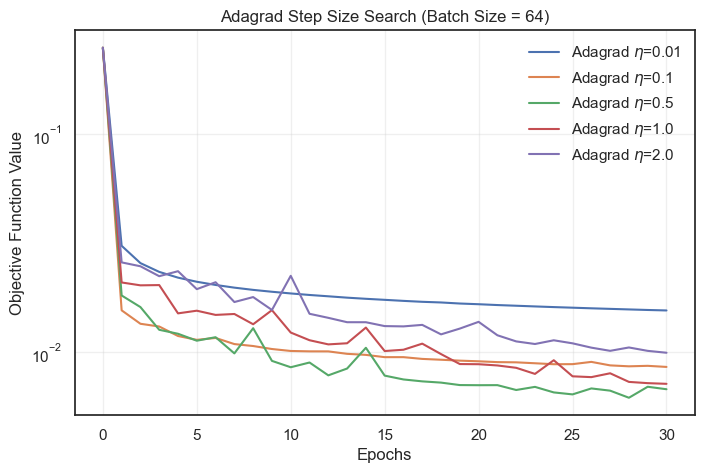

Best Adagrad step size: 0.5


In [89]:
best_batch_size = 64 
adagrad_step_sizes = [0.01, 0.1, 0.5, 1.0, 2.0]
max_epochs_ada = 30

plt.figure(figsize=(8, 5))

best_ada_loss = np.inf
best_ada_eta = None
results_ada = {}

for eta in adagrad_step_sizes:
    w_init_ada = w_init_gd.copy()
    
    _, hist_ada = adagrad(
        f, X_train, y_train, w_init_ada, 
        step_size=eta, 
        batch_size=best_batch_size, 
        max_epochs=max_epochs_ada
    )
    
    results_ada[eta] = hist_ada
    plt.plot(hist_ada, label=f'Adagrad $\\eta$={eta}')
    
    if hist_ada[-1] < best_ada_loss:
        best_ada_loss = hist_ada[-1]
        best_ada_eta = eta

plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.title(f'Adagrad Step Size Search (Batch Size = {best_batch_size})')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Best Adagrad step size: {best_ada_eta}")

Now we can compare the convergence of the tuned Adagrad against the best SGD configuration from the previous exercise.

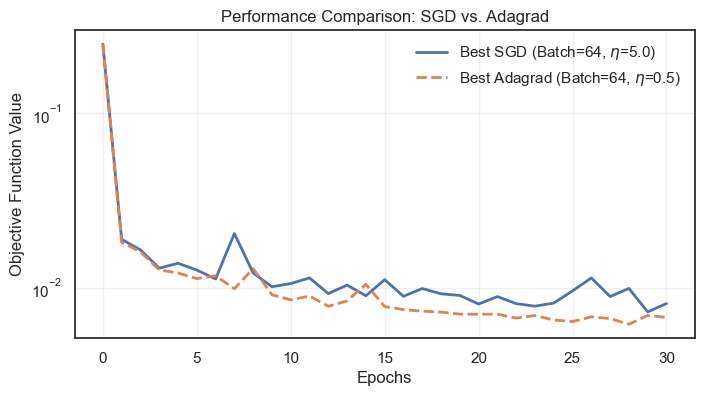

In [90]:
w_init_cmp = w_init_gd.copy()
_, hist_best_sgd = stochastic_gradient_descent(
    f, X_train, y_train, w_init_cmp, 
    step_size=5.0, 
    batch_size=64, 
    max_epochs=30
)

hist_best_ada = results_ada[best_ada_eta]

plt.figure(figsize=(8, 4))

plt.plot(hist_best_sgd, label=f'Best SGD (Batch=64, $\\eta$=5.0)', linewidth=2)
plt.plot(hist_best_ada, label=f'Best Adagrad (Batch=64, $\\eta$={best_ada_eta})', linewidth=2, linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Objective Function Value')
plt.title('Performance Comparison: SGD vs. Adagrad')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Does Adagrad converge faster?** When compared to the best stochastic gradient method from the previous question, Adagrad exhibits a faster rate of convergence. The automatic decay of the effective learning rate acts as a self-regulating mechanism, preventing the oscillations often seen in standard SGD with high learning rates while avoiding the slow progress of low learning rates. Consequently, Adagrad provides a more stable and efficient optimization trajectory for this problem.

---
# Exercise 5
> Consider the best method from Question 4, and apply it to problem (3) using proximal gradient (consider the implementation used as illustration in class, or implement your own). Can you find a value for λ that yields a good yet sparse solution vector?

We want to solve the $L_1$ regularized problem (Problem 3) to induce sparsity in the solution vector $w$.
$$\min_{w \in \mathbb{R}^d} f(w) + \lambda \|w\|_1$$

We will adapt our best optimizer (Adagrad) to the Proximal Gradient setting. The proximal operator for the $L_1$ norm is the Soft Thresholding function, that leads to the proximal step:
    $$w_{k+1} = \text{sign}(u_{k+1}) \cdot \max\left(|u_{k+1}| - \lambda H_k, 0\right)$$

Also we want to find a regularization parameter $\lambda$ that yields a sparse solution (many zeros in $w$) without significantly degrading the predictive performance (Loss $f(w)$).

In [91]:
def soft_threshold(v, threshold):
    return np.sign(v) * np.maximum(np.abs(v) - threshold, 0)

def proximal_adagrad(obj_func, X, y, w_init, step_size, lam, batch_size, max_epochs=50, epsilon=1e-8):
    w = w_init.copy()
    n, d =X.shape
    G = np.zeros(d)
    
    history_loss = []
    history_sparsity = []
    
    current_loss = obj_func(w)
    history_loss.append(current_loss)
    history_sparsity.append(np.mean(w==0))
    
    for epoch in range(max_epochs):
        indices = np.arange(n)
        np.random.shuffle(indices)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(0, n, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            
            grad = grad_batch(w, X_batch, y_batch)
            
            G += grad**2
            adaptive_lr = step_size/(np.sqrt(G)+epsilon)
            u = w - adaptive_lr*grad
            
            threshold = lam * adaptive_lr
            w = soft_threshold(u, threshold)
            
        hist_loss = obj_func(w)
        sparsity = np.mean(np.abs(w)<1e-5)
        
        history_loss.append(hist_loss)
        history_sparsity.append(sparsity)
        
    return w, np.array(history_loss), np.array(history_sparsity)

Lambda: 0.00001 | Final Loss: 0.0070 | Sparsity: 38.78%
Lambda: 0.00010 | Final Loss: 0.0130 | Sparsity: 42.73%
Lambda: 0.00100 | Final Loss: 0.0257 | Sparsity: 58.67%
Lambda: 0.00500 | Final Loss: 0.0506 | Sparsity: 69.39%
Lambda: 0.01000 | Final Loss: 0.0729 | Sparsity: 73.72%
Lambda: 0.05000 | Final Loss: 0.1809 | Sparsity: 95.92%
Lambda: 0.10000 | Final Loss: 0.2500 | Sparsity: 100.00%


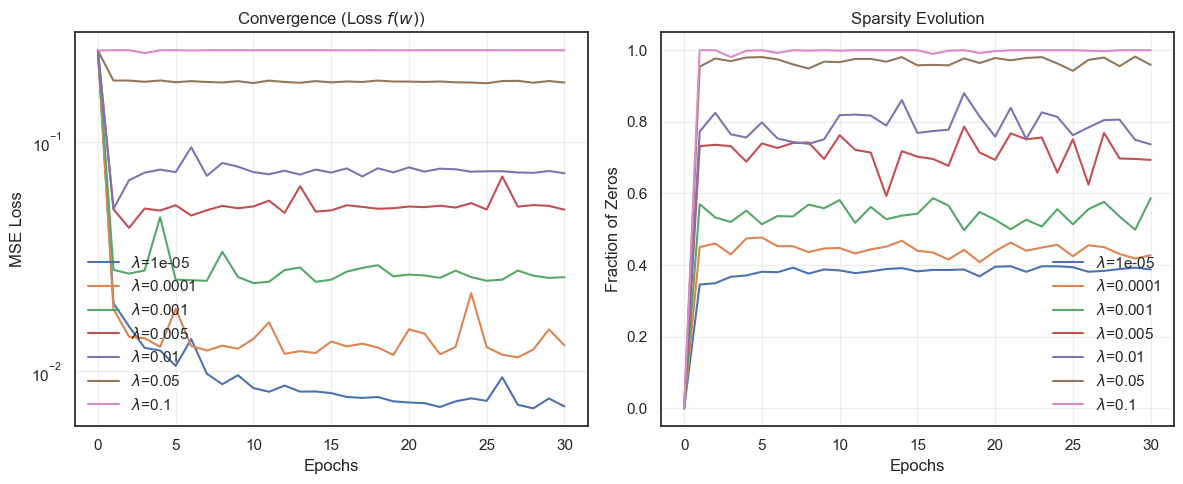

In [92]:
lambdas = [0.00001, 0.0001, 0.001, 0.005, 0.01, 0.05, 0.1]
eta_prox = 0.5 
b_prox = 64

results_prox = {}

plt.figure(figsize=(12, 5))

for lam in lambdas:
    w_init_prox = w_init_gd.copy()
    
    w_final, hist_loss, hist_spar = proximal_adagrad(
        f, X_train, y_train, w_init_prox, 
        step_size=eta_prox, 
        lam=lam, 
        batch_size=b_prox, 
        max_epochs=30
    )
    
    final_sparsity = hist_spar[-1]*100
    final_loss = hist_loss[-1]
    
    results_prox[lam] = {'w': w_final, 'loss': final_loss, 'sparsity': final_sparsity}
    
    print(f"Lambda: {lam:.5f} | Final Loss: {final_loss:.4f} | Sparsity: {final_sparsity:.2f}%")
    
    plt.subplot(1, 2, 1)
    plt.plot(hist_loss, label=f'$\\lambda$={lam}')
    
    plt.subplot(1, 2, 2)
    plt.plot(hist_spar, label=f'$\\lambda$={lam}')

plt.subplot(1, 2, 1)
plt.title('Convergence (Loss $f(w)$)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.title('Sparsity Evolution')
plt.xlabel('Epochs')
plt.ylabel('Fraction of Zeros')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In the previous plot we can see the trade-off between sparsity and loss for different values of $\lambda$. As $\lambda$ increases, the sparsity of the solution increases too, but the loss also increases, indicating a degradation in predictive performance. This is the trade-off between thed data fitting term and the regularization term.

To visualize the effect of the chosen $\lambda$ on the learned weights, we can plot the weight map and the distribution histogram, showing how many weights are exactly zero versus non-zero values:

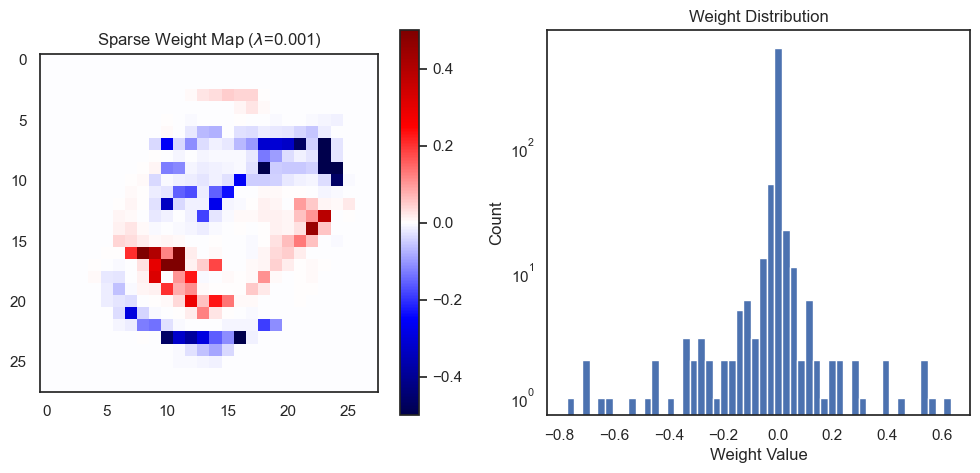

In [93]:
selected_lambda = 0.001 
w_sparse = results_prox[selected_lambda]['w']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(w_sparse.reshape(28, 28), cmap='seismic', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(f'Sparse Weight Map ($\\lambda$={selected_lambda})')

plt.subplot(1, 2, 2)
plt.hist(w_sparse, bins=50)
plt.title('Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Count')
plt.yscale('log') 

plt.show()

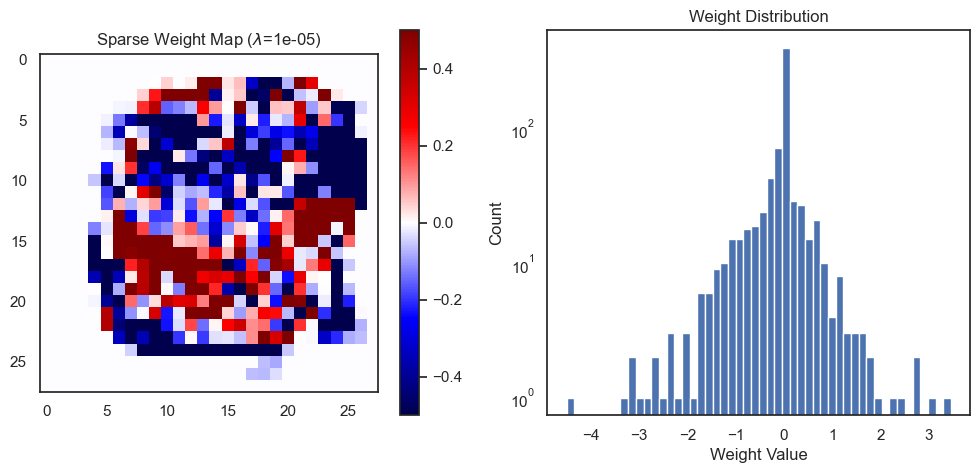

In [94]:
selected_lambda = 0.00001
w_sparse = results_prox[selected_lambda]['w']

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(w_sparse.reshape(28, 28), cmap='seismic', vmin=-0.5, vmax=0.5)
plt.colorbar()
plt.title(f'Sparse Weight Map ($\\lambda$={selected_lambda})')

plt.subplot(1, 2, 2)
plt.hist(w_sparse, bins=50)
plt.title('Weight Distribution')
plt.xlabel('Weight Value')
plt.ylabel('Count')
plt.yscale('log') 

plt.show()

The weight map for $\lambda = 0.001$ reveals that the algorithm has successfully driven the background pixels which correspond to noise and lack discriminative power to exactly zero. Consequently, the remaining non-zero weights form an interpretable template of the digit structure. We can select this $\lambda$ as a good compromise between sparsity and predictive performance.

On the other hand, with $\lambda = 0.00001$, the weight map is much denser, with more weights being different than zero. This indicates that the regularization effect is minimal at this low value of $\lambda$, leading to a solution that closely fits the training data but lacks sparsity.

---
# Exercise 6
> Implement an algorithm based on iteration 4 and validate your implementation on the linear regression problem from the notebooks.  
> i) Try different values for h in order to find one that leads to convergence.  
> ii) Try different choices for αk to obtain the best possible performance.


We want to implement a Zeroth-Order (ZO) optimization algorithm based on a randomized direct search. Unlike standard Gradient Descent, this method approximates the gradient using only function values. The update rule is given by:
$$w_{k+1} = w_k - \alpha_k \frac{f(w_k + h u_k) - f(w_k)}{h} u_k$$
where $u_k \sim \mathcal{N}(0, I_d)$ is a random Gaussian vector, $\alpha_k$ is the step size, and $h$ is a smoothing parameter.

We will validate this method on the Linear Regression problem defined in the course notebooks (the ProximalMethods one):

In [95]:
from scipy.linalg import toeplitz, norm
from numpy.random import multivariate_normal, randn

def simu_linmodel(w, n, std=1., corr=0.5):
    """
    Simulates data for a linear model with additive noise.
    (Copied from the Proximal Methods Notebook)
    """
    d = w.shape[0]
    cov = toeplitz(corr ** np.arange(0, d))
    X = multivariate_normal(np.zeros(d), cov, size=n)
    noise = std * randn(n)
    y = X.dot(w) + noise
    return X, y

In [96]:
class LinearRegressionPb:
    """
    Class for the Linear Regression problem with Least-Squares loss.
    f(w) = (1/2n) * ||Xw - y||^2
    """
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.n, self.d = X.shape

    def fun(self, w):
        return norm(self.X.dot(w)-self.y)**2/(2.*self.n)

    def grad(self, w):
        return self.X.T.dot(self.X.dot(w)-self.y)/self.n

    def get_lip_constant(self):
        return norm(self.X.T.dot(self.X),ord=2)/self.n

In [97]:
d = 50      
n = 1000    
idx = np.arange(d)
w_true = (-1)**idx*np.exp(-idx/10.) 
X, y = simu_linmodel(w_true, n, std=1., corr=0.5)
problem = LinearRegressionPb(X, y)

L = problem.get_lip_constant()
print(f"Lipschitz constant L: {L:.4f}")
print(f"Theoretical max stepsize (1/L): {1/L:.4f}")

Lipschitz constant L: 3.1507
Theoretical max stepsize (1/L): 0.3174


In [98]:
def zeroth_order_gd(w0, problem, alpha, h, n_iter=100):
    w = w0.copy()
    d = w.shape[0]
    obj_history = []
    
    for k in range(n_iter):
        f_val = problem.fun(w)
        obj_history.append(f_val)
        u = np.random.randn(d)
        
        f_val_perturbed = problem.fun(w+h*u)
        grad_est = ((f_val_perturbed-f_val)/h)*u
        
        step = alpha[k] if isinstance(alpha, (list, np.ndarray)) else alpha
        w = w - step * grad_est
        
    return w, np.array(obj_history)

**i) Impact of the smoothing parameter $h$**

We can fix a constant stepsize $\alpha$ and vary $h$. If $h$ is too large, the approximation is poor and if $h$ is too small, we might face numerical instability (though less likely in Python float64 compared to C or C++).

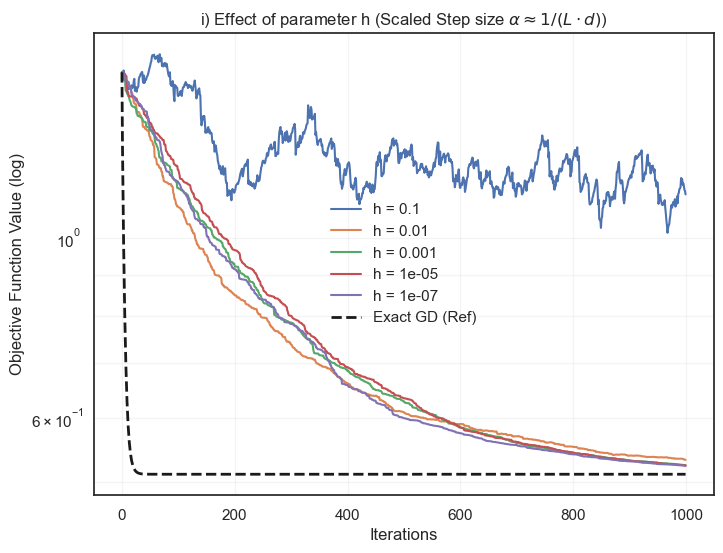

In [99]:
n_iter = 1000
w0 = np.zeros(d)

# The step size must be scaled by 1/d for Zeroth-Order methods
# because the norm of the random vector u scales with sqrt(d).
# Using the same alpha as Exact GD causes divergence.
alpha_fixed = 1.0/(L*d) 

h_values = [1e-1, 1e-2, 1e-3, 1e-5, 1e-7]

plt.figure(figsize=(8, 6))

for h in h_values:
    _, objs = zeroth_order_gd(w0, problem, alpha=alpha_fixed, h=h, n_iter=n_iter)
    plt.plot(objs, label=f'h = {h}')

w_gd = w0.copy()
gd_objs = []
for _ in range(n_iter):
    gd_objs.append(problem.fun(w_gd))
    w_gd = w_gd - (1.0/L)*problem.grad(w_gd)
    
plt.plot(gd_objs, 'k--', label='Exact GD (Ref)', linewidth=2)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value (log)')
plt.title(f'i) Effect of parameter h (Scaled Step size $\\alpha \\approx 1/(L \\cdot d)$)')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

The Zeroth-Order method converges to the minimum, but it is slower and "noisier" than exact Gradient Descent. This is expected because the gradient is estimated using a single random direction per iteration. Intermediate values (e.g., $10^{-3}$ to $10^{-5}$) tend to work best. Very large values fail to approximate the local gradient, while very small values might suffer from numerical precision issues (cancellation errors), although this is robust in simple regressions.

**ii) Impact of the step size $\alpha_k$**

Now with the fixed smoothing parameter $h$ ( 1e-5 based on the previous best result) we can try different step sizes. 

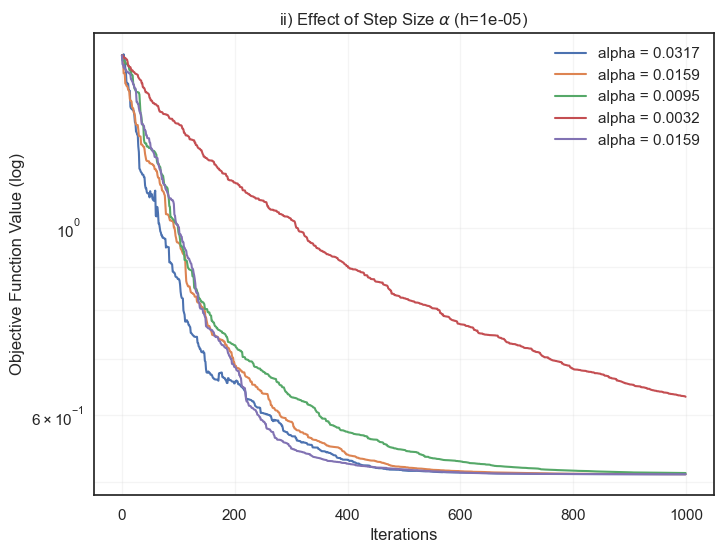

In [100]:
h_best = 1e-5 
alphas = [0.1/L, 0.05/L, 0.03/L, 0.01/L, 0.05/L]

plt.figure(figsize=(8, 6))

for alpha in alphas:
    lbl = f'alpha = {alpha:.4f}'
    if alpha == 1/L: lbl += ' (1/L)'
    
    _, objs = zeroth_order_gd(w0, problem, alpha=alpha, h=h_best, n_iter=n_iter)
    plt.plot(objs, label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value (log)')
plt.title(f'ii) Effect of Step Size $\\alpha$ (h={h_best})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

One thing to notice is that for Zeroth-Order methods, the effective step size often needs to be smaller than standard Gradient Descent because the variance of the gradient estimator introduces noise, if we use 1/L as a reference step size the algorithm tends to diverge:

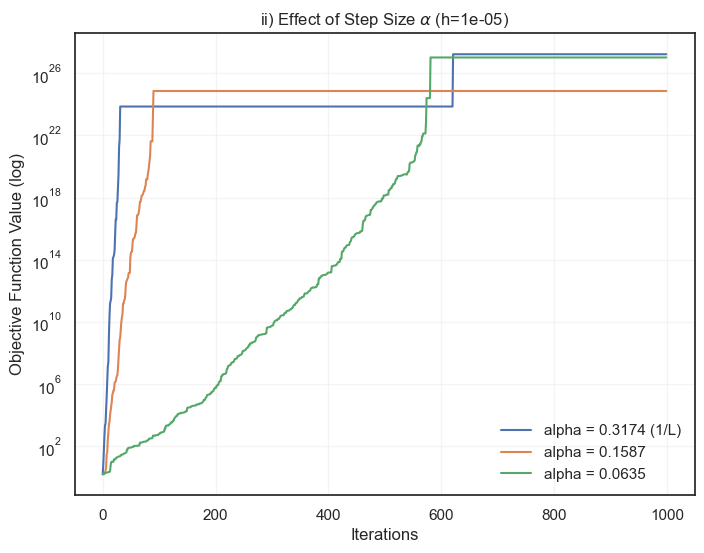

In [101]:
alphas = [1/L, 0.5/L, 0.2/L] # Testing around 1/L

plt.figure(figsize=(8, 6))

for alpha in alphas:
    lbl = f'alpha = {alpha:.4f}'
    if alpha == 1/L: lbl += ' (1/L)'
    
    _, objs = zeroth_order_gd(w0, problem, alpha=alpha, h=h_best, n_iter=n_iter)
    
    plt.plot(objs, label=lbl)

plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel('Objective Function Value (log)')
plt.title(f'ii) Effect of Step Size $\\alpha$ (h={h_best})')
plt.legend()
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

As shown the method is more sensitive to the step size than exact GD. Since the update direction is random, a large step size can easily destabilize the path. A smaller step size (e.g., $0.5/L$ or $0.1/L$) often yields smoother and more reliable convergence.

---
# Exercise 7

>Compare the performance of your algorithm with that of gradient descent and the finite-difference method on problem (1).  
>i) How do the variants behave with constant stepsize? Decreasing stepsizes?  
>ii) Propose a unit of comparison (other than the number of iterations) for all three algorithms. Plot the behavior of the methods for a fixed budget of the cost you propose.

We want to compare three optimization strategies on the MNIST binary classification problem (Eq 1):

In [ ]:
def finite_difference_gradient(w, X, y, loss_func, h=1e-5):
    d = w.shape[0]
    grad_est = np.zeros(d)
    f_w = loss_func(w, X, y) # 1 eval
    
    for j in range(d):
        w_perturbed = w.copy()
        w_perturbed[j] +=h
        f_w_h = loss_func(w_perturbed, X, y) # d evals total
        grad_est[j] = (f_w_h-f_w)/h
        
    return grad_est

def get_step_size(alpha_0, k, schedule='constant', decay_rate=0.01):
    if schedule == 'constant':
        return alpha_0
    elif schedule == 'decreasing':
        return alpha_0/(1.0+decay_rate*k)
    return alpha_0

def run_comparison(X, y, w0, steps_gd, steps_zo, steps_fd, alpha, schedule='constant'):
    d = w0.shape[0]
    h_param = 1e-4 

    # 1. Exact Gradient Descent
    # Assumption for Cost: 1 Gradient calculation ~ 2 Function evaluations (Backprop cost)
    print(f"1. Exact GD ({steps_gd} steps)...")
    w = w0.copy()
    hist_gd = {'loss': [f(w)], 'calls': [0]}
    
    for k in range(steps_gd):
        lr = get_step_size(alpha, k, schedule)
        g = grad_f(w)
        w = w-lr*g
        
        hist_gd['loss'].append(f(w))
        hist_gd['calls'].append(hist_gd['calls'][-1] + 2) 

    # 2. ZO Gaussian
    # Cost: 2 evaluations per step
    print(f"2. ZO Gaussian ({steps_zo} steps)...")
    w = w0.copy()
    hist_zo = {'loss': [f(w)], 'calls': [0]}
    
    for k in range(steps_zo):
        lr = get_step_size(alpha, k, schedule)
        u = np.random.normal(0, 1, size=d)
        
        f_val = f(w)
        f_val_plus = f(w+h_param*u)
        
        g_est = ((f_val_plus-f_val)/h_param)*u
        w = w - lr * g_est
        
        hist_zo['loss'].append(f(w))
        hist_zo['calls'].append(hist_zo['calls'][-1] + 2)

    # 3. Finite Difference
    # Cost: d + 1 evaluations per step
    w = w0.copy()
    hist_fd = {'loss': [f(w)], 'calls': [0]}
    
    for k in range(steps_fd):
        if k % 10 == 0: print(f"   FD Step {k}/{steps_fd}")
        lr = get_step_size(alpha, k, schedule)
        
        g_est = finite_difference_gradient(w, X, y, lambda w_v, x_d, y_d: f(w_v), h_param)
        w = w-lr*g_est
        
        hist_fd['loss'].append(f(w))
        hist_fd['calls'].append(hist_fd['calls'][-1] + (d + 1))
        
    return {"GD": hist_gd, "ZO": hist_zo, "FD": hist_fd}

In [ ]:
ITER_GD = 200
ITER_ZO = 4000 
ITER_FD = 20   
ALPHA = 0.5    

results_const = run_comparison(X_train, y_train, w_0, ITER_GD, ITER_ZO, ITER_FD, ALPHA, schedule='constant')

results_dec = run_comparison(X_train, y_train, w_0, ITER_GD, ITER_ZO, ITER_FD, ALPHA*2, schedule='decreasing')

1. Exact GD (200 steps)...
2. ZO Gaussian (4000 steps)...
   FD Step 0/20
   FD Step 10/20
1. Exact GD (200 steps)...
2. ZO Gaussian (4000 steps)...
   FD Step 0/20
   FD Step 10/20


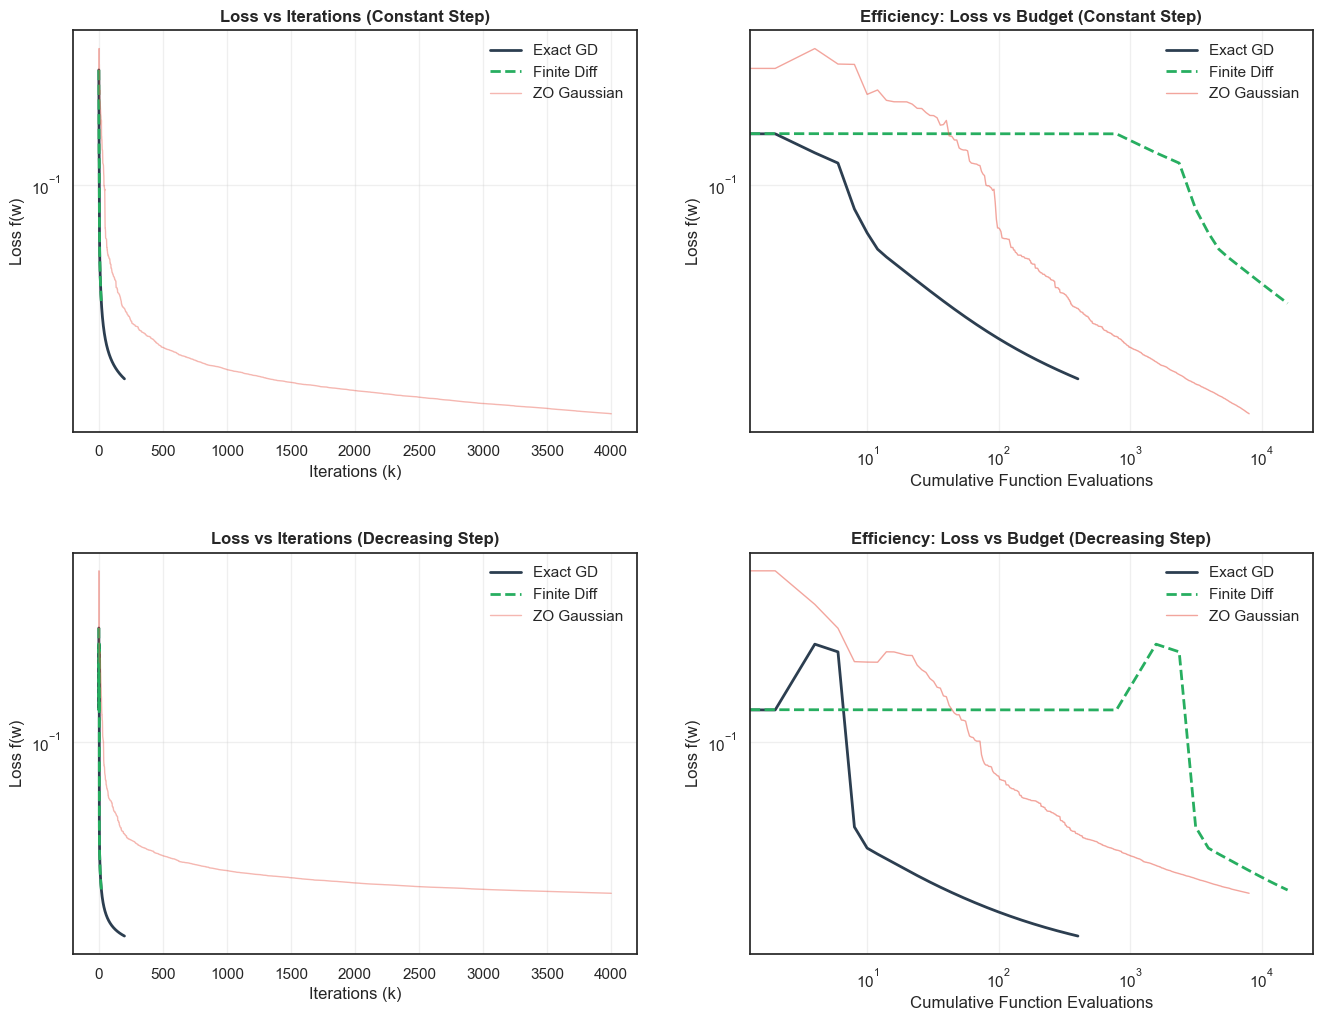

In [104]:
fig, ax = plt.subplots(2, 2, figsize=(16, 12), dpi=100)
plt.subplots_adjust(hspace=0.3)

colors = {'GD': '#2c3e50', 'FD': '#27ae60', 'ZO': '#e74c3c'}

def plot_row(axes_row, res_data, title_suffix):
    axes_row[0].plot(res_data['GD']['loss'], label='Exact GD', color=colors['GD'], lw=2)
    axes_row[0].plot(res_data['FD']['loss'], label='Finite Diff', color=colors['FD'], lw=2, ls='--')
    axes_row[0].plot(res_data['ZO']['loss'], label='ZO Gaussian', color=colors['ZO'], alpha=0.4, lw=1)
    
    axes_row[0].set_title(f'Loss vs Iterations ({title_suffix})', fontweight='bold')
    axes_row[0].set_ylabel('Loss f(w)')
    axes_row[0].set_xlabel('Iterations (k)')
    axes_row[0].set_yscale('log')
    axes_row[0].grid(True, alpha=0.3)
    axes_row[0].legend()

    axes_row[1].plot(res_data['GD']['calls'], res_data['GD']['loss'], label='Exact GD', color=colors['GD'], lw=2)
    axes_row[1].plot(res_data['FD']['calls'], res_data['FD']['loss'], label='Finite Diff', color=colors['FD'], lw=2, ls='--')
    axes_row[1].plot(res_data['ZO']['calls'], res_data['ZO']['loss'], label='ZO Gaussian', color=colors['ZO'], alpha=0.5, lw=1)
    
    axes_row[1].set_title(f'Efficiency: Loss vs Budget ({title_suffix})', fontweight='bold')
    axes_row[1].set_ylabel('Loss f(w)')
    axes_row[1].set_xlabel('Cumulative Function Evaluations')
    axes_row[1].set_xscale('log')
    axes_row[1].set_yscale('log')
    axes_row[1].grid(True, alpha=0.3)
    axes_row[1].legend()

plot_row(ax[0], results_const, "Constant Step")

plot_row(ax[1], results_dec, "Decreasing Step")

plt.show()

**i) Behavior with Constant and Decreasing Stepsizes**  
With a constant step size, both the Exact Gradient Descent and the Finite-Difference variants exhibit rapid initial convergence; however, the Finite-Difference method closely mirrors the trajectory of Exact Gradient Descent per iteration because it approximates the true gradient with high precision. In contrast, the Zero-Order Gaussian method demonstrates significant volatility and fails to converge to a high-precision solution, settling instead into a noise floor where the loss fluctuates around a certain value.   

 When a decreasing step size schedule is applied, the performance of the Zero-Order method improves noticeably. The decaying learning rate effectively mitigates the noise inherent in the random gradient estimation, allowing the algorithm to continue minimizing the loss function over time rather than oscillating, although it still converges significantly slower than the methods utilizing exact or high-precision gradient information.

**ii) Unit of Comparison and Efficiency**  
To fairly compare algorithms that possess vastly different computational costs per iteration, the most appropriate unit of comparison is the cumulative number of function evaluations. While the number of iterations measures algorithmic steps, it fails to account for the computational expense required to compute those steps. The efficiency plots generated based on this metric demonstrate a clear hierarchy in performance. Exact Gradient Descent proves to be the most efficient, achieving the lowest loss with the fewest function evaluations. The Finite-Difference method, despite following an optimal path in terms of iterations, suffers heavily from the curse of dimensionality, its cost scales linearly with the problem dimension (d+1 evaluations per step), shifting its efficiency curve drastically to the right and making it computationally prohibitive for high-dimensional problems compared to Exact Gradient Descent. Meanwhile, the Zero-Order Gaussian method, while cheap per iteration (requiring only two function evaluations), produces low-quality gradient estimates that necessitate a vastly larger number of steps to reduce the loss, ultimately rendering it less efficient than using exact gradients for this convex problem.


---
# Exercise 8

In this section, we want to adapt the Zeroth-Order Gaussian method to the stochastic setting using mini-batches.

1.  **Same-Batch Estimate (Eq 6):** We use the same batch $\mathcal{S}_k$ to evaluate both $f(w_k)$ and $f(w_k + h u_k)$.
    $$w_{k+1} = w_k - \alpha_k \frac{f_{\mathcal{S}_k}(w_k + h u_k) - f_{\mathcal{S}_k}(w_k)}{h} u_k$$

2.  **Diff-Batch Estimate (Eq 7):** We use two independent batches $\mathcal{S}_k$ and $\mathcal{S}_k^+$ (or simply re-sample).
    $$w_{k+1} = w_k - \alpha_k \frac{f_{\mathcal{S}_k^+}(w_k + h u_k) - f_{\mathcal{S}_k}(w_k)}{h} u_k$$

In [ ]:
def get_batch_loss(w, X_batch, y_batch):
    z = X_batch.dot(w)
    
    z = np.clip(z, -500, 500)
    predictions = 1 / (1 + np.exp(-z))
    
    residuals = y_batch - predictions
    return np.mean(residuals**2)

def zeroth_order_optimization(w_init, X, y, loss_func, h, step_size, n_iterations):
    w = w_init.copy()
    n, d = X.shape
    loss_history = []
    
    current_loss = loss_func(w, X, y)
    loss_history.append(current_loss)
    
    for k in range(n_iterations):
        u = np.random.normal(0, 1, size=d)
        
        if np.isnan(w).any():
            break

        loss_w_plus = loss_func(w+h*u, X, y)
        loss_w = loss_func(w, X, y) 
        diff = (loss_w_plus-loss_w)/h
        
        if np.abs(diff) > 1e10: 
            diff = np.sign(diff)*1e10 
            
        grad_est = diff*u
        w = w - step_size*grad_est
        
        current_loss = loss_func(w, X, y)
        if k % 10 == 0:
            loss_history.append(current_loss)
        
    return w, np.array(loss_history)

def zo_stochastic_same_batch(w_init, X, y, h, step_size, batch_size, n_iterations):
    """
    Equation (6): Uses the SAME batch for f(w) and f(w+hu).
    """
    w = w_init.copy()
    n, d = X.shape
    loss_history = []
    
    loss_history.append(f(w)) 
    
    for k in range(n_iterations):
        indices = np.random.randint(0, n, batch_size)
        X_b = X[indices]
        y_b = y[indices]
        
        u = np.random.normal(0, 1, size=d)

        loss_w = get_batch_loss(w, X_b, y_b)
        loss_w_plus = get_batch_loss(w+h*u, X_b, y_b)
        
        diff = (loss_w_plus-loss_w)/h
        grad_est = diff*u
        w = w - step_size*grad_est
        
        if k % 10 == 0:
            loss_history.append(f(w))
            
    return w, np.array(loss_history)

def zo_stochastic_diff_batch(w_init, X, y, h, step_size, batch_size, n_iterations):
    """
    Equation (7): Uses DIFFERENT batches for f(w) and f(w+hu).
    """
    w = w_init.copy()
    n, d = X.shape
    loss_history = []
    loss_history.append(f(w))
    
    for k in range(n_iterations):
        idx1 = np.random.randint(0, n, batch_size)
        X_b1, y_b1 = X[idx1], y[idx1]

        idx2 = np.random.randint(0, n, batch_size)
        X_b2, y_b2 = X[idx2], y[idx2]
        
        u = np.random.normal(0, 1, size=d)
        
        loss_w = get_batch_loss(w, X_b1, y_b1)
        loss_w_plus = get_batch_loss(w+h*u, X_b2, y_b2)
        
        diff = (loss_w_plus-loss_w)/h
        grad_est = diff*u
        w = w - step_size*grad_est
        
        if k % 10 == 0:
            loss_history.append(f(w))
            
    return w, np.array(loss_history)

**i) Comparison: Batch Size = 1 vs Deterministic**

Here we verify if the "Same-Batch" and "Diff-Batch" methods work with the extreme case of `batch_size=1`. "Same-Batch" should behave somewhat like Stochastic Gradient Descent (noisy but converging). "Diff-Batch" is expected to be extremely unstable because the variance of the estimator explodes when the batch size is small and $h$ is small.

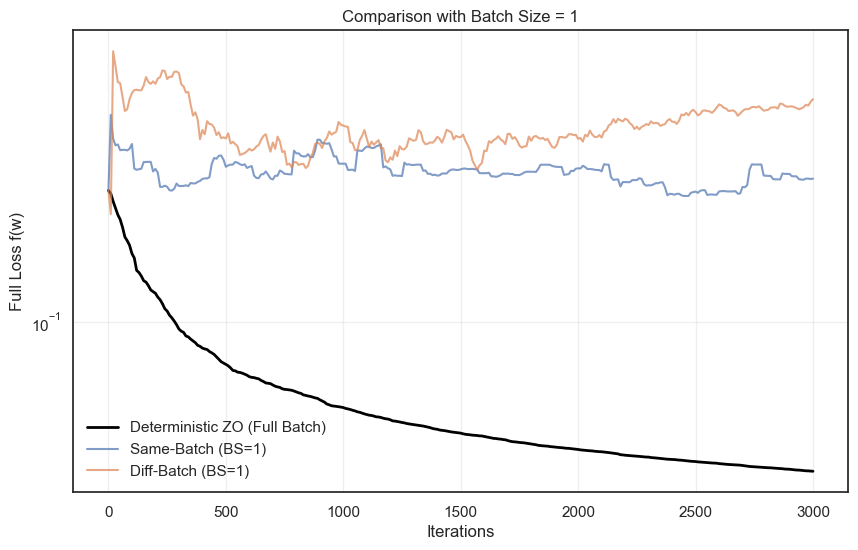

In [119]:
n_iter_stoch = 3000
batch_size_small = 1
h_val = 1e-4
alpha_stoch = 0.1

w_det, hist_det = zeroth_order_optimization(w_0, X_train, y_train, 
                                            lambda w,x,y: f(w), # using the full batch wrapper
                                            h=h_val, step_size=0.005, n_iterations=n_iter_stoch)

w_sb, hist_sb = zo_stochastic_same_batch(w_0, X_train, y_train, 
                                         h=h_val, step_size=alpha_stoch, 
                                         batch_size=batch_size_small, n_iterations=n_iter_stoch)

w_db, hist_db = zo_stochastic_diff_batch(w_0, X_train, y_train, 
                                         h=h_val, step_size=alpha_stoch, 
                                         batch_size=batch_size_small, n_iterations=n_iter_stoch)


plt.figure(figsize=(10, 6))

x_det = np.linspace(0, n_iter_stoch, len(hist_det))
plt.plot(x_det, hist_det, label='Deterministic ZO (Full Batch)', linewidth=2, color='black')

x_stoch = np.arange(0, n_iter_stoch + 1, 10) 
x_sb = np.linspace(0, n_iter_stoch, len(hist_sb))
x_db = np.linspace(0, n_iter_stoch, len(hist_db))

plt.plot(x_sb, hist_sb, label=f'Same-Batch (BS={batch_size_small})', alpha=0.7)
plt.plot(x_db, hist_db, label=f'Diff-Batch (BS={batch_size_small})', alpha=0.7)

plt.title(f'Comparison with Batch Size = {batch_size_small}')
plt.xlabel('Iterations')
plt.ylabel('Full Loss f(w)')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

The deterministic method utilizes the full dataset to produce a smooth, steep descent, serving as an ideal baseline free of sampling noise. Conversely, the Same-Batch stochastic variant with a batch size of 1 initially decreases the loss but eventually stagnates and oscillates significantly above the optimal value. This behavior aligns with first-order stochastic gradient descent observations, where high variance from small batches prevents convergence to the precise minimum when using a constant step size. Finally, the Diff-Batch variant fails completely, as using independent samples for finite differences amplifies variance by $1/h^2$, overwhelming the gradient estimate with noise.

**ii) Finding a good Batch Size**  
Now we try to stabilize the methods (especially the Diff-Batch variant) by increasing the batch size.

Running Same-Batch BS=1...
Running Same-Batch BS=16...
Running Same-Batch BS=64...
Running Same-Batch BS=256...
Running Same-Batch BS=1024...
Running Same-Batch BS=10551...
Running Diff-Batch BS=1...
Running Diff-Batch BS=16...
Running Diff-Batch BS=64...
Running Diff-Batch BS=256...
Running Diff-Batch BS=1024...
Running Diff-Batch BS=10551...


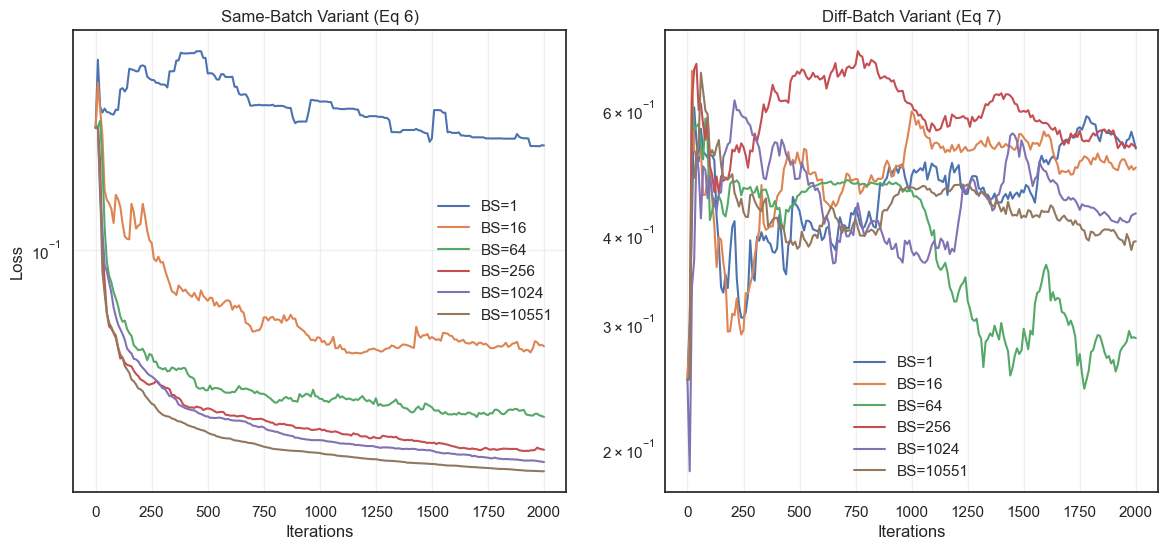

In [107]:
batch_sizes = [1, 16, 64, 256, 1024, X_train.shape[0]] 
h_val = 1e-4
alpha = 0.2
n_iter = 2000

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
for bs in batch_sizes:
    print(f"Running Same-Batch BS={bs}...")
    _, hist = zo_stochastic_same_batch(w_0, X_train, y_train, h=h_val, step_size=alpha, batch_size=bs, n_iterations=n_iter)
    x_axis = np.linspace(0, n_iter, len(hist))
    plt.plot(x_axis, hist, label=f'BS={bs}')

plt.title('Same-Batch Variant (Eq 6)')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
for bs in batch_sizes:
    print(f"Running Diff-Batch BS={bs}...")
    _, hist = zo_stochastic_diff_batch(w_0, X_train, y_train, h=h_val, step_size=alpha, batch_size=bs, n_iterations=n_iter)
    x_axis = np.linspace(0, n_iter, len(hist))
    plt.plot(x_axis, hist, label=f'BS={bs}')

plt.title('Diff-Batch Variant (Eq 7)')
plt.xlabel('Iterations')
plt.yscale('log')
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()

These plots demonstrate the sensitivity of both methods to the batch size hyperparameter, revealing a clear winner in the comparison. The Same-Batch variant exhibits a consistent improvement as the batch size increases; larger batches reduce the variance of the gradient estimator, leading to smoother curves that eventually recover the performance of the deterministic full-batch algorithm (brown line). In contrast, the Diff-Batch variant remains highly unstable across most regimes. Even with larger batch sizes, the method struggles to find a consistent descent path because the fundamental issue of subtracting loss values computed on different data subsets persists. The batch size 64 appears to be a sweet spot for the Diff-Batch method, for Same-Batch, batch sizes near the full dataset yield the best performance.

---
# Exercise 9

> Propose an adaptation of your best stochastic zeroth-order variant to the proximal setting. Compare the resulting method with the algorithm from Question 5 on problem (3) with exact gradients and finite-difference gradients.

### 9.1 Adaptation to the Proximal Setting

Problem (3) involves an $L_1$ regularization term:
$$\min_{w \in \mathbb{R}^d} f(w) + \lambda \|w\|_1$$

To solve this using Zeroth-Order (ZO) methods, we adapt the Proximal Gradient Descent algorithm. Instead of using the true gradient $\nabla f(w)$, we use our stochastic zeroth-order estimator $g_{ZO}(w)$.

The update rule becomes:
1. **Gradient Step:** $v_{k+1} = w_k - \alpha_k g_{ZO}(w_k)$
2. **Proximal Step:** $w_{k+1} = \text{prox}_{\alpha_k \lambda \|\cdot\|_1} (v_{k+1})$

Where the proximal operator for the $L_1$ norm is the Soft-Thresholding operator, as seen before. We will use the Same-Batch Stochastic ZO estimator (from Eq 6) as our best variant.

In [ ]:
def soft_thresholding(x, gamma):
    return np.sign(x) * np.maximum(np.abs(x) - gamma, 0)

def prox_zo_stochastic_optimization(w_init, X, y, h, step_size, lam, batch_size, n_iterations):
    """
    Proximal Stochastic Zeroth-Order Optimization (Same-Batch Variant)
    """
    w = w_init.copy()
    n, d = X.shape
    loss_history = []
    
    
    for k in range(n_iterations):
        idx = np.random.randint(0, n, batch_size)
        X_b = X[idx]
        y_b = y[idx]
        
        u = np.random.normal(0, 1, size=d)
        
        loss_w = get_batch_loss(w, X_b, y_b)
        loss_w_plus = get_batch_loss(w+h*u, X_b, y_b)
        
        diff = (loss_w_plus-loss_w)/h
        g_est = diff*u
        v = w-step_size*g_est
        
        w = soft_thresholding(v, step_size*lam)
        
        if k % 10 == 0:
            f_val = f(w) 
            reg_val = lam*np.sum(np.abs(w))
            loss_history.append(f_val+reg_val)
            
    return w, np.array(loss_history)

def prox_exact_gradient_descent(w_init, X, y, step_size, lam, n_iterations):
    """
    Proximal Exact Gradient Descent (Baseline from Q5 context)
    """
    w = w_init.copy()
    loss_history = []
    
    for k in range(n_iterations):
        g = grad_f(w) 
        
        v = w - step_size * g
        w = soft_thresholding(v, step_size * lam)
        
        if k % 10 == 0:
            f_val = f(w)
            reg_val = lam * np.sum(np.abs(w))
            loss_history.append(f_val + reg_val)
            
    return w, np.array(loss_history)

def prox_finite_difference_descent(w_init, X, y, h, step_size, lam, n_iterations):
    """
    Proximal Finite Difference Gradient Descent
    """
    w = w_init.copy()
    loss_history = []
    
    for k in range(n_iterations):
        g_est = finite_difference_gradient(w, X, y, lambda w_v, x_d, y_d: f(w_v), h)
        
        v = w - step_size * g_est
        w = soft_thresholding(v, step_size * lam)
        
        if k % 10 == 0:
            f_val = f(w)
            reg_val = lam * np.sum(np.abs(w))
            loss_history.append(f_val + reg_val)
            
    return w, np.array(loss_history)

Comparing the three proximal variants:

In [109]:
lam = 0.001
alpha = 0.1 
n_iter = 500
batch_size = 64
h = 1e-4

w0 = np.zeros(X_train.shape[1])

w_prox_gd, hist_prox_gd = prox_exact_gradient_descent(
    w0, X_train, y_train, step_size=alpha, lam=lam, n_iterations=n_iter
)

w_prox_zo, hist_prox_zo = prox_zo_stochastic_optimization(
    w0, X_train, y_train, h=h, step_size=alpha, lam=lam, batch_size=batch_size, n_iterations=n_iter
)

n_iter_fd = 50 
w_prox_fd, hist_prox_fd = prox_finite_difference_descent(
    w0, X_train, y_train, h=h, step_size=alpha, lam=lam, n_iterations=n_iter_fd
)

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
C:\Users\leona\AppData\Local\Temp\ipykernel_16716\3219794455.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.title(f'Comparison of Proximal Methods ($\lambda$={lam})')


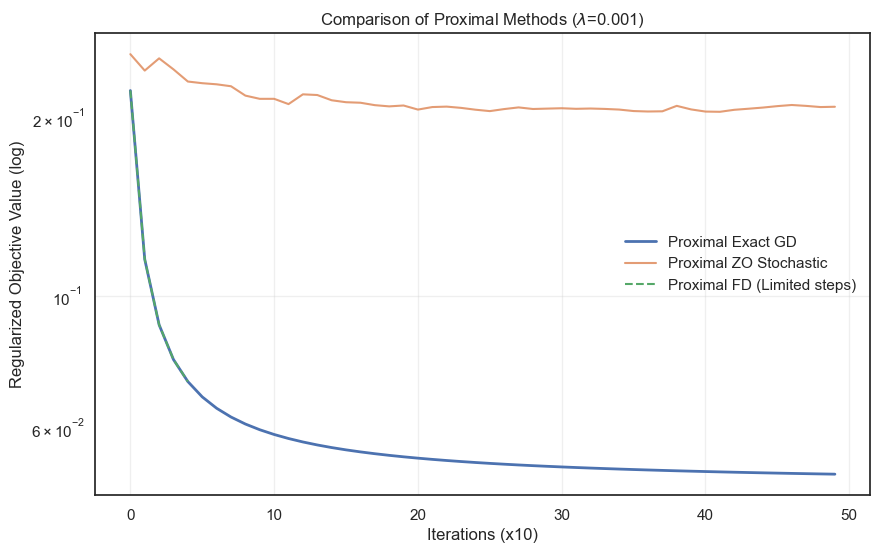

Sparsity achieved (Exact GD): 63.52%
Sparsity achieved (ZO Stochastic): 0.00%


In [110]:
plt.figure(figsize=(10, 6))
plt.plot(hist_prox_gd, label='Proximal Exact GD', linewidth=2)
plt.plot(hist_prox_zo, label='Proximal ZO Stochastic', alpha=0.8)
plt.plot(range(len(hist_prox_fd)), hist_prox_fd, label='Proximal FD (Limited steps)', linestyle='--')

plt.yscale('log')
plt.xlabel('Iterations (x10)')
plt.ylabel('Regularized Objective Value (log)')
plt.title(f'Comparison of Proximal Methods ($\lambda$={lam})')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

sparsity_zo = np.mean(w_prox_zo == 0)
sparsity_gd = np.mean(w_prox_gd == 0)
print(f"Sparsity achieved (Exact GD): {sparsity_gd:.2%}")
print(f"Sparsity achieved (ZO Stochastic): {sparsity_zo:.2%}")

The results show the trade-off between computational cost and convergence speed across the three proximal methods. As expected, the Proximal Exact Gradient Descent serves as the optimal baseline, achieving the fastest and smoothest convergence since it utilizes perfect gradient information combined with the soft-thresholding operator. The Stochastic Zeroth-Order adaptation successfully minimizes the objective function and induces sparsity, proving that derivative-free methods can be effectively combined with non-smooth proximal operators; however, it exhibits a slower convergence rate and higher variance due to the nature of the Gaussian gradient estimator. Finally, while the Finite Difference method theoretically approximates the true gradient well, its high computational cost per iteration makes it impractical for high-dimensional problems like MNIST compared to the randomized zeroth-order approach.

---